In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

C:\Users\woodw\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\woodw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, Softmax, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras import activations
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

Using TensorFlow backend.


In [55]:
# load all captions
captions = pd.read_csv('./coco-captions-2017-clean.csv')
annot_list = captions.values[:1600]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [57]:
# load external text embedding model (word2vec)
w2v_model = Word2Vec.load('./text_encoding.bin')

In [59]:
# encode all our captions
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(w2v_model[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [60]:
# Pad with 0-vectors to max_sequence_length
for i in range(len(captions_X)):
    captions_X[i].resize((max_sequence_length, 100))
captions_X = np.array(captions_X)

In [61]:
# Used to create the random distribution at training time
dist_mean = np.mean(captions_X)
dist_std = np.std(captions_X)
print(dist_mean, dist_std)

-0.021649377 0.64434105


In [62]:

def data_loader(file_path):
    '''
    Loads and normalizes all image files in the directory file_path.
    Returns np.array of normalized image matrices.
    '''
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [63]:
# loads in data and subsets it to the first 1600 samples
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:1600]

In [12]:
# custom metric to avoid binary accuracy rounding
import keras.metrics
def image_closeness(y_pred, y_true):
    return K.mean(1 - K.abs(y_pred - y_true), axis=-1)
keras.metrics.image_closeness = image_closeness




In [13]:
# load autoencoder and get decoder portion
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5') # transpose conv
decoder = autoencoder.layers[2]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [14]:
# freeze decoder weights
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [15]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32, 32]):
    '''
    Builds textual encoding model. This model's input is textual word2vec embedded vectors and outputs latent image size vectors.
    '''
    embedding_size = 64
    gru_size = 1024
    input_length = max_sequence_length
    input_layer = Input(shape=input_shape)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True, name='gru')(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)

    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [16]:
model_intermediate = build_intermediate_model((max_sequence_length, 100))
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27, 100)      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 1024), (None 3456000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         1049600     gru[0][1]                        
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1024)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [17]:
num_layers = len(model_intermediate.layers)
print(f'Model is {num_layers} layers deep.')

Model is 55 layers deep.


In [18]:
def build_combined_model():
    '''
    Builds combined generator model. 
    '''
    input_caption = Input(shape=(27, 100))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [19]:
model_text2img = build_combined_model()

In [20]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4580092   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,631,855
Trainable params: 4,602,061
Non-trainable params: 29,794
_________________________________________________________________


In [21]:
model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])

In [22]:
m = load_model('./text2img-models-v3/text2img-3k-epochs.h5')

In [23]:
history = m.fit(captions_X, imgs_y, epochs=1, batch_size=32, shuffle=True)
# plot_history(history)

Epoch 1/1
1600/1600 [==============================] - 9s 5ms/step - loss: 0.0818 - image_closeness: 0.7599 - acc: 0.4283


In [24]:
# Non-generative training logic
for i in range (1, 3):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#     model_text2img.save('.\\text2img-models-v5\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Epoch 1/1000
1600/1600 [==============================] - 8s 5ms/step - loss: 0.0909 - image_closeness: 0.7516 - acc: 0.3708
Epoch 2/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0792 - image_closeness: 0.7628 - acc: 0.4057
Epoch 3/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0784 - image_closeness: 0.7640 - acc: 0.4166
Epoch 4/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0782 - image_closeness: 0.7640 - acc: 0.4213
Epoch 5/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0775 - image_closeness: 0.7648 - acc: 0.4314
Epoch 6/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0784 - image_closeness: 0.7637 - acc: 0.4249
Epoch 7/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0777 - image_closeness: 0.7645 - acc: 0.4273
Epoch 8/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0771 - image_closeness: 0.7652 - acc: 0.4306


KeyboardInterrupt: 

In [75]:
# model_text2img = load_model('./text2img-models-v2/text2img-1k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4580092   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,631,855
Trainable params: 4,564,394
Non-trainable params: 67,461
_________________________________________________________________


In [23]:
# for generating figures
model_text2img_t = load_model('./text2img-models-v4/text2img-2k-epochs.h5')

In [101]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import textwrap


def rgb_imshow(img, name):
    '''
    Shows bgr opencv image in rgb.
    '''
    plt.xticks([])
    plt.yticks([])
    if name is not None:
        plt.title('\n'.join(textwrap.wrap(name, 20)), fontsize=8)
    else:
        plt.title(name)
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))

def show_converted(model, caption, noise_ratio=0.1):
    '''
    Sample from generative model using the noise ratio.
    '''
    figure(num=None, dpi=100, facecolor='w', edgecolor='k')
    caption_input = caption_encoding(caption) + noise_ratio * np.random.normal(dist_std, dist_std, (27, 100))
    target_image = testimgs[0]
    decoded_img = model.predict(np.array([caption_input]), steps=None)[0]
    rgb_imshow(decoded_img, caption)
    plt.tight_layout()
    plt.show()



In [25]:
def caption_encoding(string):
    '''
    Returns encoded caption vector from string.
    '''
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((27, 100))
    return caption_conv

In [26]:
def plot_history(history):
    '''
    Used to plot history after training.
    '''
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
def pad_text(text):
    paddings = tf.constant([[0, 0], [0, 52]])
    text = tf.pad(text, paddings, 'CONSTANT')
    return text

def build_discriminator(conv_channels=[8, 16, 32], dropout=False, residual=False, concat_captions=False):
    if concat_captions:
        text_input = Input(shape=(27, 100))
    image_input = Input(shape=(128, 128, 3))

    if concat_captions:
        text_attn = Flatten()(text_input)

    dropout_rate = 0.5

    for index, channel in enumerate(conv_channels):
        if residual:
            shortcut = Conv2D(channel, 3, padding='same', trainable=False)(image_input if index == 0 else discriminator_block)
        discriminator_block = BatchNormalization()(image_input if index == 0 else discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        discriminator_block = Conv2D(channel, 3, padding='same')(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)

        discriminator_block = BatchNormalization()(discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        discriminator_block = Conv2D(channel, 3, padding='same')(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)
        if residual:
            discriminator_block = Add()([discriminator_block, shortcut])

        discriminator_block = Conv2D(channel, 3, padding='same', strides=2)(discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)


    discriminator_block = Flatten()(discriminator_block)
    if concat_captions:
        discriminator_block = Concatenate()([discriminator_block, text_attn])

    dense = Dense(1, activation='sigmoid')(discriminator_block) #change to concatted if add text back

    return Model(image_input, dense, name='Discriminator') #Model([text_input, image_input], dense, name='Discriminator')


In [29]:
def build_gan():
    '''
    Builds generative adversarial model for training.
    '''
    input_caption = Input(shape=(27, 100))
    input_image = Input(shape=(128, 128, 3))
    generated_image = model_text2img(input_caption)
    discriminator_output = discriminator(generated_image) #discriminator([input_caption, generated_image])
    

    gan = Model(input_caption, [discriminator_output, generated_image])
    return gan




In [73]:
#logic to train descriminator in adversarial model
model_intermediate = build_intermediate_model((27, 100))
model_text2img = build_combined_model()
discriminator = build_discriminator(encode_channels=[4, 8, 16, 32, 64], dropout=True)
d_adam = keras.optimizers.adam(lr=0.00001, beta_1=0.0, beta_2=0.999)
discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
discriminator.trainable = False
adversarial_net = build_gan()
g_adam = keras.optimizers.adam(lr=0.0001, beta_1=0.0, beta_2=0.999)
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 10], metrics=['binary_accuracy'])

In [74]:
# captions_X = captions_X[:128]
# imgs_y = imgs_y[:128]
# caption_strings = caption_strings[:128]

In [107]:
from keras.utils.generic_utils import Progbar
from time import time

d_loss_means = []
d_acc_means = []
a_loss_means = []
t_loss_means = []

# custom adversarial training logic
BATCHSIZE = 32
EPOCHS = 1000
for epoch in range(EPOCHS):
    num_data_pts = len(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(imgs_y)
    np.random.seed(epoch)
    np.random.shuffle(caption_strings)

    d_hist_loss = []
    d_hist_acc = []
    a_hist_loss = []
    t_hist_loss = []
    print()
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(num_data_pts // BATCHSIZE)
    #print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    progress_bar = Progbar(target=int(num_data_pts // (BATCHSIZE)))
    minibatches_size = BATCHSIZE
    start_time = time()
    
    for index in range(int(num_data_pts // (BATCHSIZE))):
        progress_bar.update(index)
        
        #print(f'{BATCHSIZE*index}:{(BATCHSIZE*(index+1))}')
        images_real = imgs_y[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        captions_batch = captions_X[BATCHSIZE*index:(BATCHSIZE*(index+1))] + 0.1 * np.random.normal(dist_std, dist_std, (BATCHSIZE, 27, 100))
        #print(edges_batch.shape)
        labels_fake = np.zeros([BATCHSIZE,1], dtype=np.float32)
        labels_real = np.ones([BATCHSIZE,1], dtype=np.float32)
        
        images_fake = model_text2img.predict(captions_batch)
        train_imgs = np.concatenate((images_real, images_fake))
        train_captions = np.concatenate((captions_batch, captions_batch))
        train_labels = np.concatenate((labels_real, labels_fake))
        

 
        np.random.seed(index)
        np.random.shuffle(train_imgs)
        np.random.seed(index)
        np.random.shuffle(train_captions)
        np.random.seed(index)
        np.random.shuffle(train_labels)
        
        # train discrimiator every 4th epoch
        if index % 20 == 0:
            d_loss, d_acc = discriminator.train_on_batch(train_imgs, train_labels)
            d_hist_loss.append(d_loss)
            d_hist_acc.append(d_acc)

            
        a_loss_1, _, t_loss, _, t_acc = adversarial_net.train_on_batch(captions_batch, [labels_real, images_real])
        a_hist_loss.append(a_loss_1)
        t_hist_loss.append(t_loss)
        

    
    t_loss_means.append(np.mean(t_hist_loss))
    d_loss_means.append(np.mean(d_hist_loss))
    a_loss_means.append(np.mean(a_hist_loss))
    d_acc_means.append(np.mean(d_hist_acc))
    print(' ' + str(np.mean(d_hist_acc)))



# adversarial_net.save_weights('.\\gan-v1\\gan-2k-epochs-weights.h5')
# model_text2img.save_weights('.\\gan-v1\\text2img-2k-epochs-weights.h5')


epoch 1 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 2 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 3 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 4 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 5 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 6 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 7 of 1000
49/50 [============================>.] - ETA: 0s 0.984375

epoch 8 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 9 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 10 of 1000
49/50 [============================>.] - ETA: 0s 0.9947917

epoch 11 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 12 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 13 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 14 of 10


epoch 108 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 109 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 110 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 111 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 112 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 113 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 114 of 1000
49/50 [============================>.] - ETA: 0s 0.9791667

epoch 115 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 116 of 1000
49/50 [============================>.] - ETA: 0s 0.984375

epoch 117 of 1000
49/50 [============================>.] - ETA: 0s 0.9895833

epoch 118 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 119 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 120 of 1000
49/50 [============================>.] - ETA: 0s 0.953

49/50 [============================>.] - ETA: 0s 0.96875

epoch 320 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 321 of 1000
49/50 [============================>.] - ETA: 0s 0.9479167

epoch 322 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 323 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 324 of 1000
49/50 [============================>.] - ETA: 0s 0.9375

epoch 325 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 326 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 327 of 1000
49/50 [============================>.] - ETA: 0s 0.9322917

epoch 328 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 329 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 330 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 331 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 332 of 10

49/50 [============================>.] - ETA: 0s 0.96875

epoch 426 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 427 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 428 of 1000
49/50 [============================>.] - ETA: 0s 0.9947917

epoch 429 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 430 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 431 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 432 of 1000
49/50 [============================>.] - ETA: 0s 0.9427083

epoch 433 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 434 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 435 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 436 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 437 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 43


epoch 636 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 637 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 638 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 639 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 640 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 641 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 642 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 643 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 644 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 645 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 646 of 1000
49/50 [============================>.] - ETA: 0s 0.953125

epoch 647 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 648 of 1000
49/50 [============================>.] - ETA: 0s 0.96

49/50 [============================>.] - ETA: 0s 0.953125

epoch 848 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 849 of 1000
49/50 [============================>.] - ETA: 0s 0.9635417

epoch 850 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 851 of 1000
49/50 [============================>.] - ETA: 0s 0.9791667

epoch 852 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 853 of 1000
49/50 [============================>.] - ETA: 0s 1.0

epoch 854 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 855 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 856 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 857 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 858 of 1000
49/50 [============================>.] - ETA: 0s 0.9895833

epoch 859 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 860 of 1000
4


epoch 953 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 954 of 1000
49/50 [============================>.] - ETA: 0s 0.9583333

epoch 955 of 1000
49/50 [============================>.] - ETA: 0s 0.9791667

epoch 956 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 957 of 1000
49/50 [============================>.] - ETA: 0s 0.984375

epoch 958 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 959 of 1000
49/50 [============================>.] - ETA: 0s 0.9791667

epoch 960 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 961 of 1000
49/50 [============================>.] - ETA: 0s 0.9791667

epoch 962 of 1000
49/50 [============================>.] - ETA: 0s 1.0

epoch 963 of 1000
49/50 [============================>.] - ETA: 0s 0.9739583

epoch 964 of 1000
49/50 [============================>.] - ETA: 0s 0.96875

epoch 965 of 1000
49/50 [============================>.] - ETA: 0s 0.963

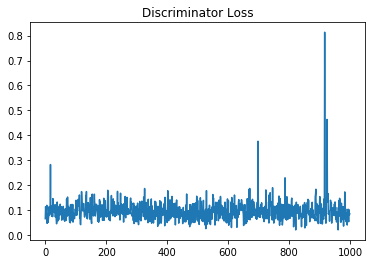

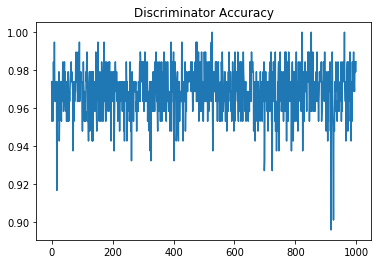

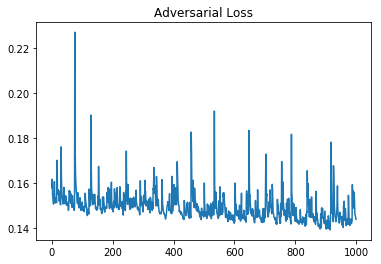

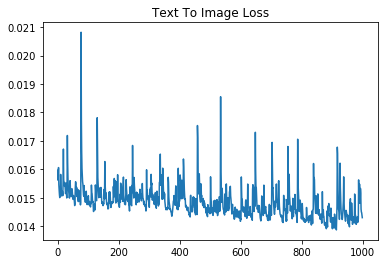

In [108]:
from matplotlib import pyplot as plt
plt.title('Discriminator Loss')
plt.plot(d_loss_means)
# plt.savefig('./gan-v1/discriminator_loss-2k')
plt.show()
plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
# plt.savefig('./gan-v1/discriminator_acc-2k')
plt.show()
plt.title('Adversarial Loss')
plt.plot(a_loss_means)
# plt.savefig('./gan-v1/adversarial_loss-2k')
plt.show()
plt.title('Text To Image Loss')
plt.plot(t_loss_means)
# plt.savefig('./gan-v1/text2img_loss-2k')
plt.show()

10


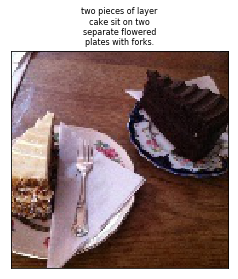

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


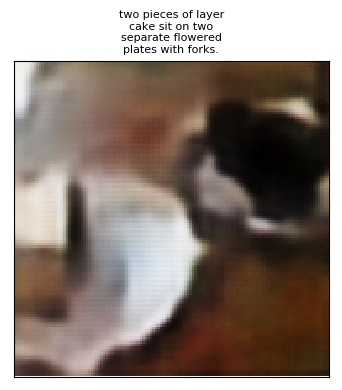

11


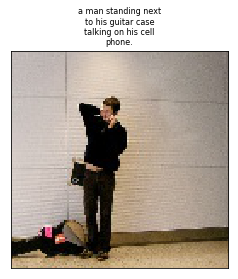

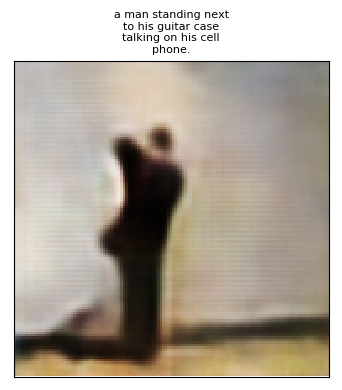

12


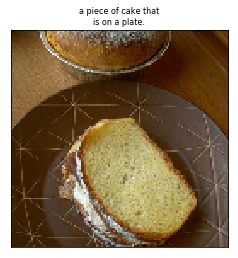

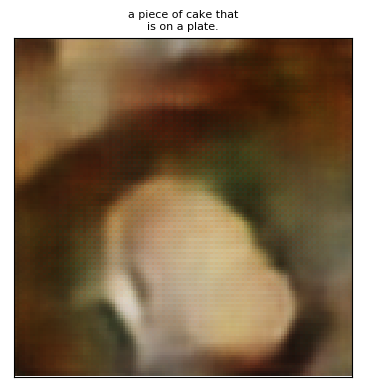

13


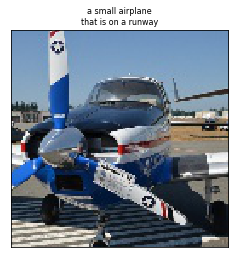

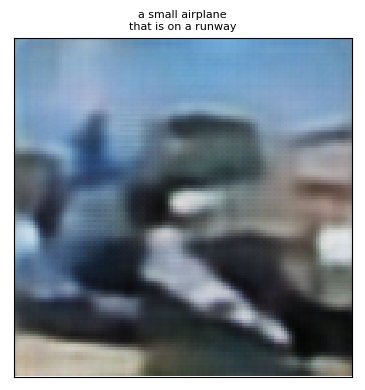

14


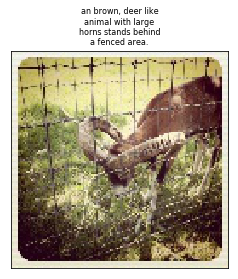

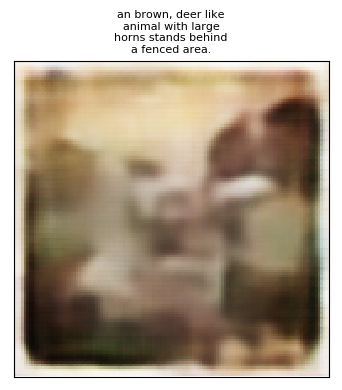

15


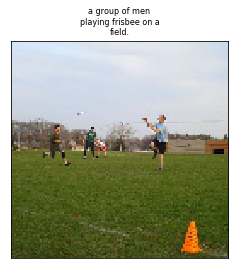

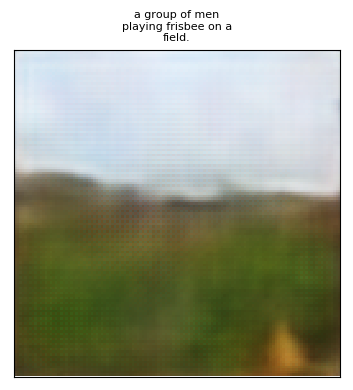

16


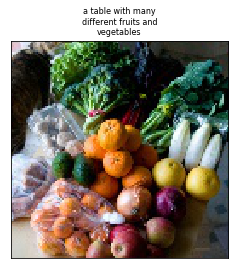

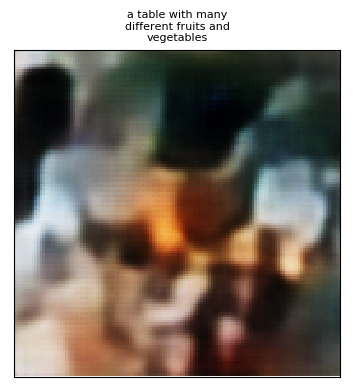

17


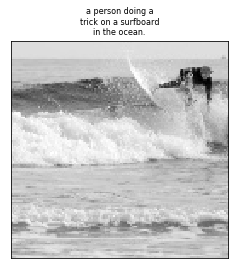

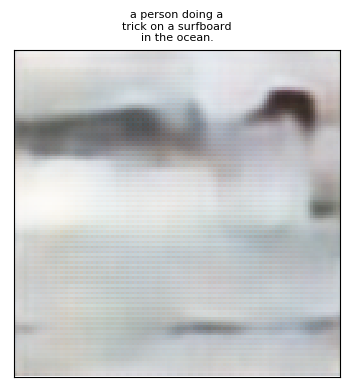

18


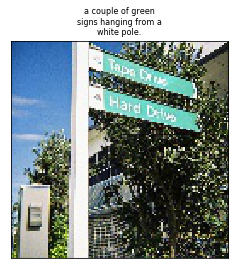

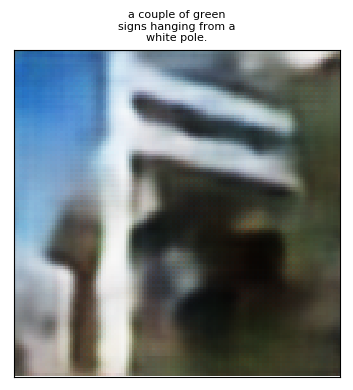

19


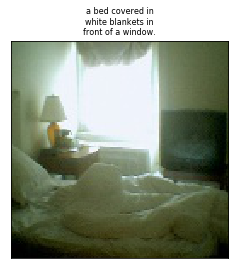

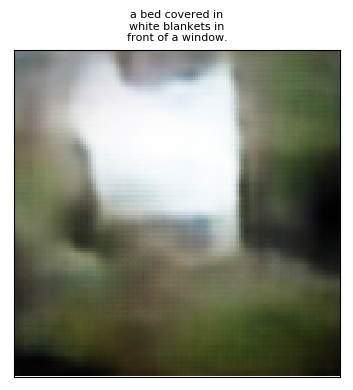

In [109]:

#vault for storing good images
vault = range(10, 20)
for img_num in vault:
    print(img_num)
    rgb_imshow(imgs_y[img_num], caption_strings[img_num]) 
    plt.show()
    show_converted(model_text2img, caption_strings[img_num])
